In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.utils import shuffle

from torch.autograd import Function, Variable
import torch
from torch import nn

In [2]:
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
plt.rc('legend', fontsize=10)

width = 5
height = width/1.618

In [3]:
np.random.seed(0)
torch.manual_seed(0)

In [4]:
# Differentiable logistic regression in PyTorch
class LR(Function):
    @staticmethod
    def forward(ctx, X, y, C):
        # X is N by n
        # y is N by 1 of (-1, 1)
        N, n = X.shape
        y = y.squeeze()
        lr = LogisticRegression(C=C.item(), fit_intercept=True)
        lr.fit(X.data.numpy(), y.data.numpy())
        theta = Variable(torch.Tensor(np.concatenate([lr.coef_.flatten(), lr.intercept_])))
        X1 = torch.cat([X.clone(), Variable(torch.ones(N, 1))], dim=1)
        pi = 1./(1.+torch.exp(-y*(X1.mm(theta.unsqueeze(-1)).squeeze())))
        s1 = C*(pi-1)*y
        
        eye = torch.eye(n+1); eye[-1,-1] = 0. # no regularization on intercept
        s2 = torch.inverse(eye + C*X1.t().mm(torch.diag(pi*(1-pi)).mm(X1)))
        ctx.save_for_backward(s1, s2)
        ctx.N = N
        
        return theta
        
    @staticmethod
    def backward(ctx, grad_output):
        s1, s2 = ctx.saved_tensors
        s3 = grad_output.unsqueeze(0).mm(s2)
        s3 = s3.repeat([ctx.N,1])
        return -(s1.unsqueeze(-1)*s3)[:,:-1], None, None
    
lr = LR.apply

In [5]:
def get_data(N):
    r1 = np.random.normal(1.,.4,size=N//2)
    theta1 = np.random.uniform(-np.pi,np.pi,size=N//2)
    r2 = np.random.normal(2.,.4,size=N//2)
    theta2 = np.random.uniform(-np.pi,np.pi,size=N//2)
    
    X = np.r_[
        np.c_[r1*np.cos(theta1),r1*np.sin(theta1)],
        np.c_[r2*np.cos(theta2),r2*np.sin(theta2)],
    ]
    y = np.r_[
        -np.ones(N//2),
        np.ones(N//2)
    ]
    return X,y

In [6]:
ntrain = 60
ntest = 1000
n = 2
X, y = get_data(ntrain)
Xt, yt = get_data(ntest)

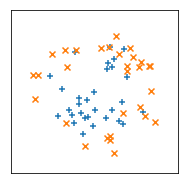

In [7]:
fig = plt.figure()
plt.scatter(X[:ntrain//2,0],X[:ntrain//2,1],marker='+')
plt.scatter(X[ntrain//2:,0],X[ntrain//2:,1],marker='x')
plt.xlim(-3,3)
plt.ylim(-3,3)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
fig.set_size_inches(3,3)
plt.show()

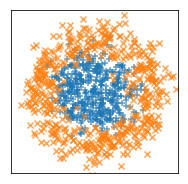

In [8]:
fig = plt.figure()
plt.scatter(Xt[:ntest//2,0],Xt[:ntest//2,1],marker='+',alpha=.7)
plt.scatter(Xt[ntest//2:,0],Xt[ntest//2:,1],marker='x',alpha=.7)
plt.xlim(-3,3)
plt.ylim(-3,3)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
fig.set_size_inches(3,3)
plt.savefig('figures/data-test.pdf')
plt.show()

In [9]:
X_train = Variable(torch.Tensor(X), requires_grad=False)
y_train = Variable(torch.Tensor(y), requires_grad=False)

Xtv = Variable(torch.Tensor(Xt), requires_grad=False)
ytv = Variable(torch.Tensor(yt), requires_grad=False)

In [10]:
# split into K random partitions
K = 256
f = .95
Xs_train = Variable(torch.zeros(K, int(ntrain*f), n))
ys_train = Variable(torch.zeros(K, int(ntrain*f)))
Xs_val = Variable(torch.zeros(K, ntrain-int(ntrain*f), n))
ys_val = Variable(torch.zeros(K, ntrain-int(ntrain*f)))

for i in range(K):
    indices = np.random.permutation(ntrain)
    
    training_idx, val_idx = indices[:int(ntrain*f)], indices[int(ntrain*f):]
    training_idx = torch.LongTensor(training_idx)
    val_idx = torch.LongTensor(val_idx)
    
    Xs_train[i] = X_train[training_idx]; ys_train[i] = y_train[training_idx]
    Xs_val[i] = X_train[val_idx]; ys_val[i] = y_train[val_idx]

In [11]:
C = Variable(torch.Tensor([10.]), requires_grad=False)
net = nn.Sequential(nn.Linear(X.shape[1], 64), nn.ReLU(), nn.Linear(64,X.shape[1]))
optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)

0.7010239362716675
0.563


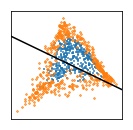

0.701734721660614
0.565


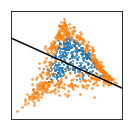

0.7021452784538269
0.571


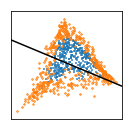

0.7021668553352356
0.578


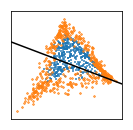

0.7016749978065491
0.585


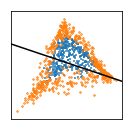

0.7004764676094055
0.593


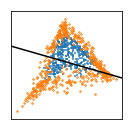

0.6982731223106384
0.6


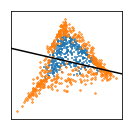

0.6945729851722717
0.617


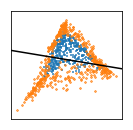

0.688533365726471
0.653


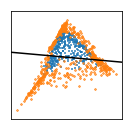

0.6786030530929565
0.685


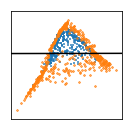

0.661752462387085
0.725


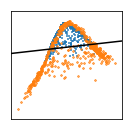

0.6319788694381714
0.77


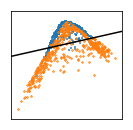

0.5812278985977173
0.831


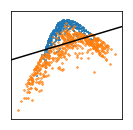

0.5256880521774292
0.844


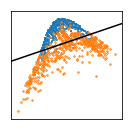

0.49396970868110657
0.87


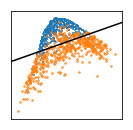

0.4717984199523926
0.868


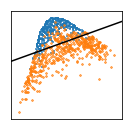

0.45862606167793274
0.876


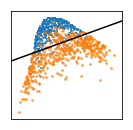

0.4476895034313202
0.88


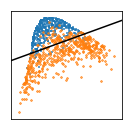

0.4399934709072113
0.881


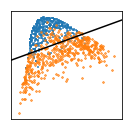

0.4335155189037323
0.886


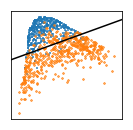

0.42826247215270996
0.888


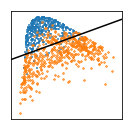

0.4237731993198395
0.888


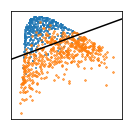

0.4198908507823944
0.89


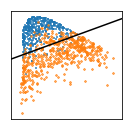

0.4164731204509735
0.888


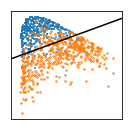

0.4134230613708496
0.887


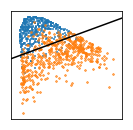

0.41066959500312805
0.886


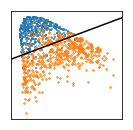

0.4081598222255707
0.888


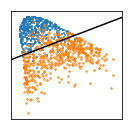

0.4058496356010437
0.888


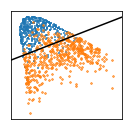

0.40371018648147583
0.887


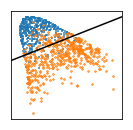

0.4017152190208435
0.888


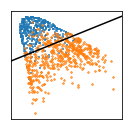

0.3998401165008545
0.888


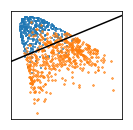

0.39807236194610596
0.888


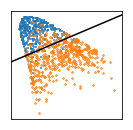

0.39639484882354736
0.889


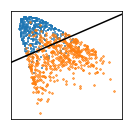

0.3947916328907013
0.891


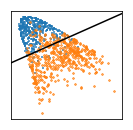

0.39325225353240967
0.891


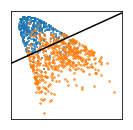

0.391766220331192
0.891


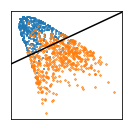

0.39032283425331116
0.893


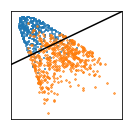

0.38890212774276733
0.894


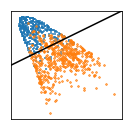

0.3874674141407013
0.895


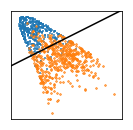

0.3860454261302948
0.894


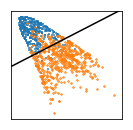

0.38462355732917786
0.894


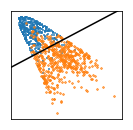

0.38317641615867615
0.894


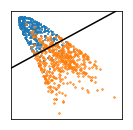

0.38169002532958984
0.895


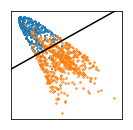

0.38012516498565674
0.896


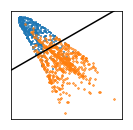

0.3784472644329071
0.896


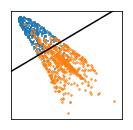

0.3765963315963745
0.896


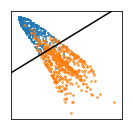

0.37452858686447144
0.896


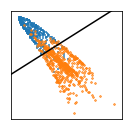

0.3722259998321533
0.896


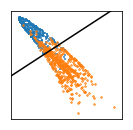

0.3697721064090729
0.896


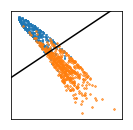

0.36744236946105957
0.896


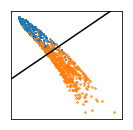

0.3655504584312439
0.896


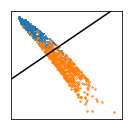

0.3641323447227478
0.896


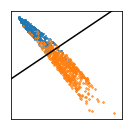

0.36301302909851074
0.897


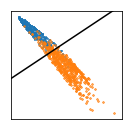

0.36203721165657043
0.898


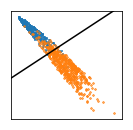

0.36113640666007996
0.897


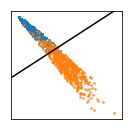

0.3602847456932068
0.899


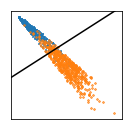

0.3594716489315033
0.899


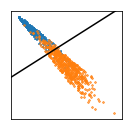

0.35868287086486816
0.899


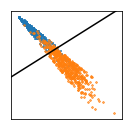

0.35791710019111633
0.899


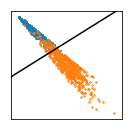

0.357178270816803
0.899


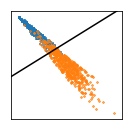

0.3564552068710327
0.899


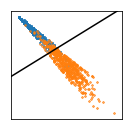

0.35575270652770996
0.899


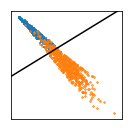

0.3550577461719513
0.899


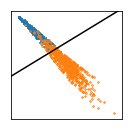

0.3543856739997864
0.899


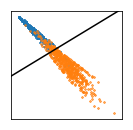

0.35372570157051086
0.899


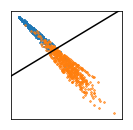

0.3530738055706024
0.898


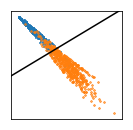

0.3524426817893982
0.898


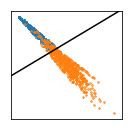

0.35182178020477295
0.898


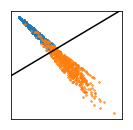

0.3512064218521118
0.898


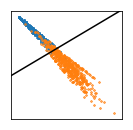

0.3506094813346863
0.898


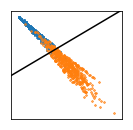

0.35001811385154724
0.898


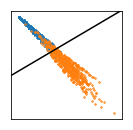

0.3494279682636261
0.898


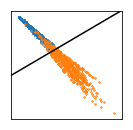

0.34885361790657043
0.898


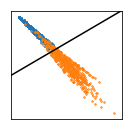

0.3482837378978729
0.898


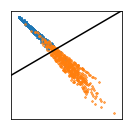

0.34772688150405884
0.898


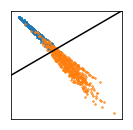

0.34717464447021484
0.898


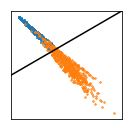

0.3466271162033081
0.898


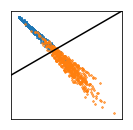

0.34609222412109375
0.898


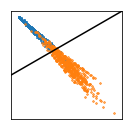

0.34556466341018677
0.898


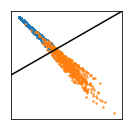

0.3450431823730469
0.898


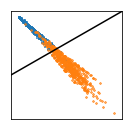

0.3445301949977875
0.898


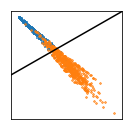

0.34402671456336975
0.898


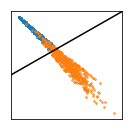

0.3435218632221222
0.898


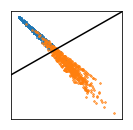

0.34303200244903564
0.898


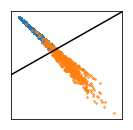

0.34254980087280273
0.898


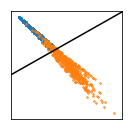

0.342061847448349
0.898


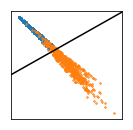

0.3415885865688324
0.898


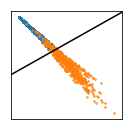

0.3411181569099426
0.898


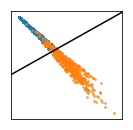

0.34065940976142883
0.898


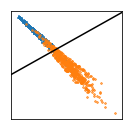

0.34020674228668213
0.898


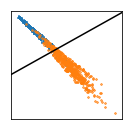

0.3397562503814697
0.898


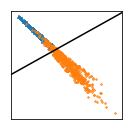

0.3393173813819885
0.898


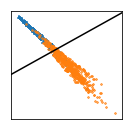

0.3388812839984894
0.898


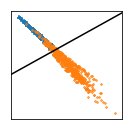

0.33845055103302
0.899


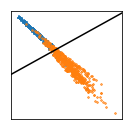

0.3380270004272461
0.898


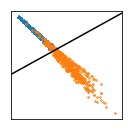

0.33759984374046326
0.898


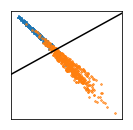

0.33718517422676086
0.898


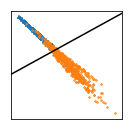

0.3367668688297272
0.899


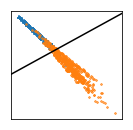

0.3363613784313202
0.898


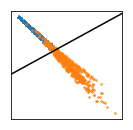

0.3359537720680237
0.899


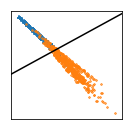

In [12]:
def closure():
    bce = torch.nn.BCEWithLogitsLoss()
    optimizer.zero_grad()
    loss = 0.
    for i in range(K):
        theta = lr(net(Xs_train[i]),ys_train[i],C)
        pi = torch.cat([net(Xs_val[i]).detach(), Variable(torch.ones(Xs_val[i].shape[0], 1))], dim=1).mm(theta.unsqueeze(-1))
        loss += torch.nn.SoftMarginLoss()(pi.squeeze(),ys_val[i])/K
    print (loss.item())
    loss.backward()
    return loss

for i in range(100):
#     if i % 1 == 0:
    optimizer.step(closure)
    theta = lr(net(X_train).detach(), y_train, C)
    pi =  torch.cat([net(Xtv).detach(), Variable(torch.ones(Xtv.shape[0], 1))], dim=1).mm(theta.unsqueeze(-1))
    print (((pi > 0).data.numpy().flatten() == (ytv.data.numpy().flatten() + 1.) / 2).mean())
    
    # plots
    Xtransformed = net(Xtv).data.numpy()
    fig = plt.figure()
    plt.scatter(Xtransformed[:500,0],Xtransformed[:500,1],marker='+',alpha=.7,s=3)
    plt.scatter(Xtransformed[500:,0],Xtransformed[500:,1],marker='x',alpha=.7,s=3)
    xlim = (np.min(Xtransformed[:,0])-.1,np.max(Xtransformed[:,0])+.1)
    ylim= (np.min(Xtransformed[:,1])-.1,np.max(Xtransformed[:,1])+.1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    fig.set_size_inches(2,2)
    theta1,theta2,theta3 = theta[0].data.item(),theta[1].data.item(),theta[2].data.item()
    plt.plot([-5,5],[-theta1/theta2*(-5)-theta3/theta2,-theta1/theta2*(5)-theta3/theta2],c='black')
    plt.savefig('figures/data-%d.pdf' % i)
    plt.show()
#     print (((torch.norm(Xtv,dim=1) > 1.5).data.numpy().flatten() == (ytv.data.numpy().flatten() + 1.) / 2).mean())

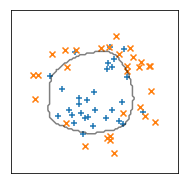

In [13]:
def decision(xy):
    xy = net(Variable(torch.Tensor(xy))).data.numpy().flatten()
    return theta[0].data.item()*xy[0] + theta[1].data.item()*xy[1] + theta[2].data.item() > 0
xx = np.linspace(-3,3,100)
yy = np.linspace(-3,3,100)
YY, XX = np.meshgrid(yy, xx)
Z = np.zeros(XX.shape)
for i in range(len(xx)):
    for j in range(len(yy)):
        Z[i,j] = decision([xx[i],yy[j]])

# plot decision boundary and margins
fig = plt.figure()
plt.scatter(X[:ntrain//2,0],X[:ntrain//2,1],marker='+')
plt.scatter(X[ntrain//2:,0],X[ntrain//2:,1],marker='x')
plt.xlim(-3,3)
plt.ylim(-3,3)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
fig.set_size_inches(3,3)
plt.contour(XX, YY, Z, colors='black', levels=[0], alpha=0.5)
plt.savefig('figures/data.pdf')
plt.show()

In [14]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(2,64)
        self.linear2 = nn.Linear(64,2)
        self.linear3 = nn.Linear(2,1)
    def forward(self, x):
        x = self.linear1(x)
        x = nn.ReLU()(x)
        z = self.linear2(x)
        return z, self.linear3(z)

In [15]:
def learn_mlp(X_train, y_train, Xtv, ytv):
    mlp = MLP()

    for _ in range(100):
        optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-2)
        z, x = mlp(X_train)
        loss = torch.nn.SoftMarginLoss()(x.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        z, x = mlp(Xtv)
        test_loss = ((x > 0).data.numpy().flatten() == ((ytv.data.numpy()+1.)/2).flatten()).mean()
    return test_loss

In [16]:
learn_mlp(X_train, y_train, Xtv, ytv)

0.877

In [17]:
ntrains = range(8,100,4)
tl = []
tl_lr = []
tl_nn = []
tl_bayes = []
for j in range(10):
    test_losses = []
    test_losses_lr = []
    test_losses_nn = []
    test_losses_bayes = []
    for ntrain in ntrains:
        n = 2
        X, y = get_data(ntrain)
        Xt, yt = get_data(ntest)

        X_train = Variable(torch.Tensor(X), requires_grad=False)
        y_train = Variable(torch.Tensor(y), requires_grad=False)

        Xtv = Variable(torch.Tensor(Xt), requires_grad=False)
        ytv = Variable(torch.Tensor(yt), requires_grad=False)

        # split into K random partitions
        K = 256
        f = .95
        Xs_train = Variable(torch.zeros(K, int(ntrain*f), n))
        ys_train = Variable(torch.zeros(K, int(ntrain*f)))
        Xs_val = Variable(torch.zeros(K, ntrain-int(ntrain*f), n))
        ys_val = Variable(torch.zeros(K, ntrain-int(ntrain*f)))

        for i in range(K):
            indices = np.random.permutation(ntrain)

            training_idx, val_idx = indices[:int(ntrain*f)], indices[int(ntrain*f):]
            training_idx = torch.LongTensor(training_idx)
            val_idx = torch.LongTensor(val_idx)

            Xs_train[i] = X_train[training_idx]; ys_train[i] = y_train[training_idx]
            Xs_val[i] = X_train[val_idx]; ys_val[i] = y_train[val_idx]

        lrc = LogisticRegression()
        lrc.fit(X, y)
        lr_loss = (lrc.predict(Xt) == yt).mean()
        test_losses_lr.append(lr_loss)

        C = Variable(torch.Tensor([10.]), requires_grad=False)
        net = nn.Sequential(nn.Linear(X.shape[1], 64), nn.ReLU(), nn.Linear(64,X.shape[1]))
        optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)

        def closure():
            bce = torch.nn.BCEWithLogitsLoss()
            optimizer.zero_grad()
            loss = 0.
            for i in range(K):
                theta = lr(net(Xs_train[i]),ys_train[i],C)
                pi = torch.cat([net(Xs_val[i]).detach(), Variable(torch.ones(Xs_val[i].shape[0], 1))], dim=1).mm(theta.unsqueeze(-1))
                loss += torch.nn.SoftMarginLoss()(pi.squeeze(),ys_val[i])/K
            loss.backward()
            return loss

        for i in range(100):
            optimizer.step(closure)
            theta = lr(net(X_train).detach(), y_train, C)
            pi =  torch.cat([net(Xtv).detach(), Variable(torch.ones(Xtv.shape[0], 1))], dim=1).mm(theta.unsqueeze(-1))
            test_loss = (((pi > 0).data.numpy().flatten() == (ytv.data.numpy().flatten() + 1.) / 2).mean())
        test_losses.append(test_loss)
        print (test_loss)

        mlp_test_loss = learn_mlp(X_train, y_train, Xtv, ytv)
        test_losses_nn.append(mlp_test_loss)

        bayes_loss = (((torch.norm(Xtv,dim=1) > 1.5).data.numpy().flatten() == (ytv.data.numpy().flatten() + 1.) / 2).mean())
        test_losses_bayes.append(bayes_loss)

        print ("ntrain: %d | lr_acc: %.4f | cvgm_acc: %.4f | mlp_acc: %.4f | bayes_acc: %.4f" % (ntrain, lr_loss, test_loss, mlp_test_loss, bayes_loss))
    tl.append(test_losses)
    tl_lr.append(test_losses_lr)
    tl_nn.append(test_losses_nn)
    tl_bayes.append(test_losses_bayes)
    print ('Iteration', j)

0.845
ntrain: 8 | lr_acc: 0.5070 | cvgm_acc: 0.8450 | mlp_acc: 0.7230 | bayes_acc: 0.8820
0.768
ntrain: 12 | lr_acc: 0.5060 | cvgm_acc: 0.7680 | mlp_acc: 0.7050 | bayes_acc: 0.8940
0.861
ntrain: 16 | lr_acc: 0.5310 | cvgm_acc: 0.8610 | mlp_acc: 0.8210 | bayes_acc: 0.8890
0.856
ntrain: 20 | lr_acc: 0.5080 | cvgm_acc: 0.8560 | mlp_acc: 0.8120 | bayes_acc: 0.8980
0.844
ntrain: 24 | lr_acc: 0.5320 | cvgm_acc: 0.8440 | mlp_acc: 0.8420 | bayes_acc: 0.8970
0.854
ntrain: 28 | lr_acc: 0.4940 | cvgm_acc: 0.8540 | mlp_acc: 0.8480 | bayes_acc: 0.8730
0.832
ntrain: 32 | lr_acc: 0.4990 | cvgm_acc: 0.8320 | mlp_acc: 0.8460 | bayes_acc: 0.9000
0.844
ntrain: 36 | lr_acc: 0.5260 | cvgm_acc: 0.8440 | mlp_acc: 0.8640 | bayes_acc: 0.8930
0.829
ntrain: 40 | lr_acc: 0.5270 | cvgm_acc: 0.8290 | mlp_acc: 0.8070 | bayes_acc: 0.8860
0.87
ntrain: 44 | lr_acc: 0.5100 | cvgm_acc: 0.8700 | mlp_acc: 0.8420 | bayes_acc: 0.8910
0.871
ntrain: 48 | lr_acc: 0.4450 | cvgm_acc: 0.8710 | mlp_acc: 0.8820 | bayes_acc: 0.9050
0

0.873
ntrain: 92 | lr_acc: 0.5010 | cvgm_acc: 0.8730 | mlp_acc: 0.8690 | bayes_acc: 0.8860
0.912
ntrain: 96 | lr_acc: 0.5310 | cvgm_acc: 0.9120 | mlp_acc: 0.8700 | bayes_acc: 0.9100
Iteration 3
0.618
ntrain: 8 | lr_acc: 0.5770 | cvgm_acc: 0.6180 | mlp_acc: 0.6130 | bayes_acc: 0.8720
0.89
ntrain: 12 | lr_acc: 0.5070 | cvgm_acc: 0.8900 | mlp_acc: 0.8330 | bayes_acc: 0.9010
0.71
ntrain: 16 | lr_acc: 0.5300 | cvgm_acc: 0.7100 | mlp_acc: 0.6850 | bayes_acc: 0.8990
0.838
ntrain: 20 | lr_acc: 0.5180 | cvgm_acc: 0.8380 | mlp_acc: 0.8410 | bayes_acc: 0.8960
0.876
ntrain: 24 | lr_acc: 0.4960 | cvgm_acc: 0.8760 | mlp_acc: 0.8630 | bayes_acc: 0.8880
0.883
ntrain: 28 | lr_acc: 0.5200 | cvgm_acc: 0.8830 | mlp_acc: 0.8750 | bayes_acc: 0.8950
0.841
ntrain: 32 | lr_acc: 0.5260 | cvgm_acc: 0.8410 | mlp_acc: 0.8600 | bayes_acc: 0.9080
0.9
ntrain: 36 | lr_acc: 0.5140 | cvgm_acc: 0.9000 | mlp_acc: 0.8240 | bayes_acc: 0.9100
0.863
ntrain: 40 | lr_acc: 0.4890 | cvgm_acc: 0.8630 | mlp_acc: 0.8530 | bayes_acc:

0.873
ntrain: 84 | lr_acc: 0.5020 | cvgm_acc: 0.8730 | mlp_acc: 0.8660 | bayes_acc: 0.8860
0.829
ntrain: 88 | lr_acc: 0.4820 | cvgm_acc: 0.8290 | mlp_acc: 0.8740 | bayes_acc: 0.8850
0.86
ntrain: 92 | lr_acc: 0.5080 | cvgm_acc: 0.8600 | mlp_acc: 0.8230 | bayes_acc: 0.8750
0.865
ntrain: 96 | lr_acc: 0.5340 | cvgm_acc: 0.8650 | mlp_acc: 0.7860 | bayes_acc: 0.8880
Iteration 7
0.633
ntrain: 8 | lr_acc: 0.4990 | cvgm_acc: 0.6330 | mlp_acc: 0.6800 | bayes_acc: 0.8850
0.788
ntrain: 12 | lr_acc: 0.5130 | cvgm_acc: 0.7880 | mlp_acc: 0.7530 | bayes_acc: 0.8950
0.86
ntrain: 16 | lr_acc: 0.5720 | cvgm_acc: 0.8600 | mlp_acc: 0.8050 | bayes_acc: 0.9050
0.829
ntrain: 20 | lr_acc: 0.5070 | cvgm_acc: 0.8290 | mlp_acc: 0.8000 | bayes_acc: 0.8810
0.863
ntrain: 24 | lr_acc: 0.5410 | cvgm_acc: 0.8630 | mlp_acc: 0.8450 | bayes_acc: 0.8960
0.835
ntrain: 28 | lr_acc: 0.5530 | cvgm_acc: 0.8350 | mlp_acc: 0.8240 | bayes_acc: 0.8730
0.83
ntrain: 32 | lr_acc: 0.4920 | cvgm_acc: 0.8300 | mlp_acc: 0.8380 | bayes_acc

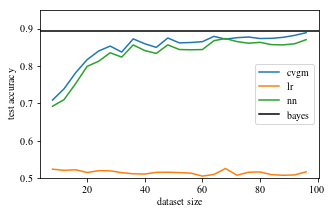

In [18]:
fig = plt.figure()
plt.plot(ntrains,np.mean(np.array(tl), axis=0), label='cvgm')
plt.plot(ntrains,np.mean(np.array(tl_lr), axis=0), label='lr')
plt.plot(ntrains,np.mean(np.array(tl_nn), axis=0), label='nn')
plt.axhline(np.mean(tl_bayes), c='black', label='bayes')
plt.legend()
fig.set_size_inches(width,height)
plt.xlabel('dataset size')
plt.ylabel('test accuracy')
plt.ylim(0.5,.95)
plt.savefig('figures/loss.pdf')
plt.show()
plt.close()

In [19]:
(np.array(tl) > np.array(tl_nn)).mean()

0.782608695652174

In [20]:
np.mean(tl_bayes)

0.894013043478261